# WOFOST Optimisation

This tutorial will cover the use of black-box optimisation on the WOFOST simulation model.

Black-box optimisation applied to the WOFOST fruit model means searching for parameter values, like growth rates or transpiration coefficients that make the model outputs best match observed LAI data, without needing access to or derivatives of the internal equations. 

The optimiser only "sees" the model's inputs and outputs, evaluating how well each trial run fits experimental or target outcomes. This approach is especially useful when the biological processes are too complex, nonlinear, or computationally expensive to model analytically, allowing calibration of WOFOST purely through iterative evaluation and intelligent search.

# Imports

We will first import all required dependencies.

In [2]:
import pandas as pd
import numpy as np
import yaml
import os.path as osp
import copy

from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)

from calisim.optimisation import OptimisationMethod, OptimisationMethodModel
from calisim.statistics import MeanSquaredError, MeanPinballLoss

import pcse
from pcse.models import Wofost72_PP
from pcse.base import ParameterProvider
from pcse.input import NASAPowerWeatherDataProvider, YAMLAgroManagementReader, YAMLCropDataProvider, WOFOST72SiteDataProvider, DummySoilDataProvider

# Observed data

We will next load the observed field data.

Climate data will be from the Netherlands (latitude=52, longitude=5).

We will set WAV (initial amount of available soil moisture in excess of the wilting point) to 50.

We will use dummy soil data.

In [4]:
wdp = NASAPowerWeatherDataProvider(latitude=52, longitude=5)
print(wdp)

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER Source Native Resolution Daily Data
----Site characteristics----
Elevation:    3.5
Latitude:  52.000
Longitude:  5.000
Data available for 1984-01-01 - 2025-10-21
Number of missing days: 0



In [5]:
sited = WOFOST72SiteDataProvider(WAV=50)
print(sited)

{'IFUNRN': 0, 'NOTINF': 0, 'SSI': 0.0, 'SSMAX': 0.0, 'WAV': 50.0, 'SMLIM': 0.4}


In [6]:
soild = DummySoilDataProvider()
print(soild)

{'SMFCF': 0.3, 'SM0': 0.4, 'SMW': 0.1, 'RDMSOL': 120, 'CRAIRC': 0.06, 'K0': 10.0, 'SOPE': 10.0, 'KSUB': 10.0}


In [8]:
cropd = YAMLCropDataProvider(fpath="data", force_reload=True)
print(cropd)

Crop parameters loaded from: /mnt/c/Users/james/projects/calisim-examples/workshop/6_wofost/data
Crop and variety not set: no active crop parameter set!



In [10]:
agro = YAMLAgroManagementReader(osp.join("data", "AGMT_C2_2020.agro"))
print(agro)

!!python/object/new:pcse.input.yaml_agro_loader.YAMLAgroManagementReader
listitems:
- 2020-04-20:
    CropCalendar:
      crop_end_date: 2020-11-03
      crop_end_type: maturity
      crop_name: potato
      crop_start_date: 2020-04-20
      crop_start_type: sowing
      max_duration: 300
      variety_name: Potato_C2_C5
    StateEvents: null
    TimedEvents: null



In [11]:
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)
wofost = Wofost72_PP(params, wdp, agro)
wofost.run_till_terminate()
observed_data = pd.DataFrame(wofost.get_output())
observed_data

,day,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
0,2020-04-20,-0.100000,0.120000,60.00000,0.000000,48.000000,12.000000,15.000000,0.000000,10.0,0.3,None
1,2020-04-21,-0.097173,0.120000,60.00000,0.000000,48.000000,12.000000,15.000000,0.000000,10.0,0.3,None
2,2020-04-22,-0.093882,0.120000,60.00000,0.000000,48.000000,12.000000,15.000000,0.000000,10.0,0.3,None
3,2020-04-23,-0.090047,0.120000,60.00000,0.000000,48.000000,12.000000,15.000000,0.000000,10.0,0.3,None
4,2020-04-24,-0.085667,0.120000,60.00000,0.000000,48.000000,12.000000,15.000000,0.000000,10.0,0.3,None
...,...,...,...,...,...,...,...,...,...,...,...,...
140,2020-09-07,1.963323,0.876336,16447.03535,11629.712391,3077.106707,1740.216253,1135.030442,0.128282,50.0,0.3,None
141,2020-09-08,1.972529,0.876336,16447.03535,11629.712391,3077.106707,1740.216253,1135.030442,0.088088,50.0,0.3,None
142,2020-09-09,1.982916,0.716347,16447.03535,11629.712391,3077.106707,1740.216253,1135.030442,0.085369,50.0,0.3,None
143,2020-09-10,1.992974,0.581502,16447.03535,11629.712391,3077.106707,1740.216253,1135.030442,0.071436,50.0,0.3,None


<Axes: xlabel='day', ylabel='LAI'>

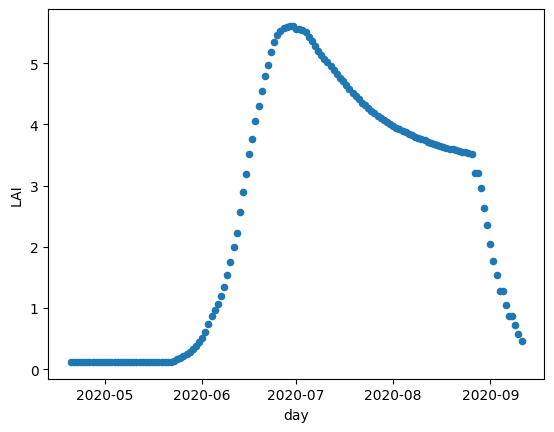

In [14]:
observed_data.plot.scatter("day", "LAI")

In [27]:
params.get("SPAN")

37.0

In [28]:
params.get("TDWI")

75.0

# Calibration procedure

## Single-objective optimisation

We will next run the calibration procedures against observed LAI data. In this case, we will perform black-box optimisation.

We begin by specifying our parameter distributions. We will calibrate 2 parameters:

- SPAN: Life span of leaves growing at 35C
- TDWI: Initial total seed tuber dry weight

Parameter ranges were taken from [Time-Dependent Sensitivity Analysis of Wofost-Potato for Temperate and Subtropical Environments (Lui et al., 2025)](https://www.sciencedirect.com/science/article/pii/S116103012500303X)

In [29]:
parameter_spec = ParameterSpecification(
	parameters=[
		DistributionModel(
			name="TDWI",
			distribution_name="uniform",
			distribution_args=[75, 700],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="SPAN",
			distribution_name="uniform",
			distribution_args=[20, 50],
			data_type=ParameterDataType.CONTINUOUS,
		),
	]
)

We'll define an objective function for our optimiser, which will return the discrepancy between observed and simulated LAI values as determined by the mean squared error (MSE) metric. We'll aim to maximise the predictive accuracy of WOFOST by minimising the MSE returned by our objective function. This is a single objective optimisation problem.

In [30]:
def objective(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    p = copy.deepcopy(params)
    for k in parameters:
        p.set_override(k, parameters[k])
                
    wofost = Wofost72_PP(p, wdp, agro)
    wofost.run_till_terminate()
    simulated_data = pd.DataFrame(wofost.get_output()).LAI.values
    
    metric = MeanSquaredError()
    discrepancy = metric.calculate(observed_data, simulated_data)
    return discrepancy

We'll next run our black-box optimisation procedure using the [Tree-Structured Parsen Estimator (TPES) from the Optuna library](https://optuna.org/).

**TPES** is a Bayesian optimisation method that uses two density-estimation surrogate models to learn the distribution of parameters from WOFOST that lead to **good** and **bad** results where:

- $l(x) = p(x \mid y < y^*) $: models parameter values that produced *good* results  
- $g(x) = p(x \mid y \ge y^*) $: models parameter values that produced *bad* results

Here $x$ are our parameter sets and $y^*$ is a performance threshold (often a quantile of observed losses). New candidate parameter sets are chosen to maximise the ratio **l(x) / g(x)**. In other words, we want to evaluate solutions that look like past winners but are still uncertain. TPES is efficient for high-dimensional and mixed-type search spaces.

[More information on TPES can be found using this link](https://arxiv.org/abs/2304.11127).

In [31]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

specification = OptimisationMethodModel(
    experiment_name="optuna_optimisation",
    parameter_spec=parameter_spec,
    observed_data=observed_data.LAI.values,
    method="tpes",
    output_labels=["Leaf Area Index Discrepancy"],
    directions=[
        "minimize"
    ],
    n_jobs=1,
    n_iterations=200,
    method_kwargs=dict(n_startup_trials=10),
)

calibrator = OptimisationMethod(
    calibration_func=objective, specification=specification, engine="optuna"
)

calibrator.specify().execute().analyze()

The empirical distribution function plot depicts the proportion of trials containing our objective value. Roughly 80% of trials have an MSE below 1.

We see diminishing results in MSE beyond trial 100. So that is when optimiser begins to converge.

The parallel coordinate plot shows us the relationship between our objective values against our 2 parameters using horizontal curves. Darker curves indicate better performance. For our parallel coordinate plot, we see less spread in the trajectories of the horizontal curves at TDWI. And greater spread for SPAN.

According to the fANOVA sensitivity analysis, TDWI is the most important parameter. This is consistent with the results of the Sobol sensitivity analysis.

Our slice plots show the sampling history of TPES over trials. It quickly converges to a solution.

We'll extract the point estimates from our calibrator.

In [33]:
optimisation_df = pd.DataFrame({
    "parameter_name": [ 
        model.name
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "parameter_estimate": [ 
        model.estimate
        for model in calibrator.get_parameter_estimates().estimates
    ]
})
optimisation_df

,parameter_name,parameter_estimate
0,SPAN,37.079960
1,TDWI,75.902295


We see the parameter estimates above for our 2 parameters. We can run WOFOST again using these optimised estimates, and compare the simulated and observed LAI values.

<Axes: xlabel='observed', ylabel='simulated'>

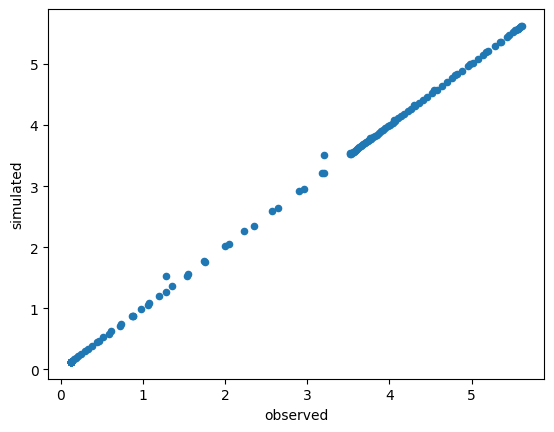

In [36]:
parameters = { 
    row["parameter_name"]: row["parameter_estimate"]
    for row in optimisation_df.to_dict("records")
}

p = copy.deepcopy(params)
for k in parameters:
    p.set_override(k, parameters[k])
        
wofost = Wofost72_PP(p, wdp, agro)
wofost.run_till_terminate()

pd.DataFrame({
    "observed": observed_data.LAI.values,
    "simulated": pd.DataFrame(wofost.get_output()).LAI.values
}).plot.scatter("observed", "simulated")

After calibration via black-box optimisation, the predictive accuracy of our WOFOST model is quite high. The model's behaviour more closely reflects that of reality.

## Multi-objective optimisation

Let's repeat this process. But this time, we will incorporate a second objective for optimisation. Hence, we are performing multi-objective optimisation rather than single-objective optimisation. [For more information, click this link](https://www.sciencedirect.com/science/article/abs/pii/S0951832005002012).

Let's aim to minimise the discrepancy between both simulated and observed TWSO (tuber dry weight) and simulated and observed LAI. We will use the mean pinball loss metric for TWSO, and the MSE for LAI.

We can re-use our parameter specification from single-objective optimisation, but we'll need to define a new objective function.

In [42]:
def objective(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    p = copy.deepcopy(params)
    for k in parameters:
        p.set_override(k, parameters[k])
                
    wofost = Wofost72_PP(p, wdp, agro)
    wofost.run_till_terminate()
    simulated_data = pd.DataFrame(wofost.get_output())
    
    
    simulated_LAI = simulated_data.LAI.values
    observed_LAI = observed_data.LAI.values
    simulated_TWSO = simulated_data.TWSO.values
    observed_TWSO = observed_data.TWSO.values 
    
    LAI_metric = MeanSquaredError()
    TWSO_metric = MeanPinballLoss()
    LAI_discrepancy = LAI_metric.calculate(observed_LAI, simulated_LAI)
    TWSO_discrepancy = TWSO_metric.calculate(observed_TWSO, simulated_TWSO)
    
    return LAI_discrepancy, TWSO_discrepancy

Let's run the multi-objective optimisation procedure, again using the TPES algorithm from the Optuna library.

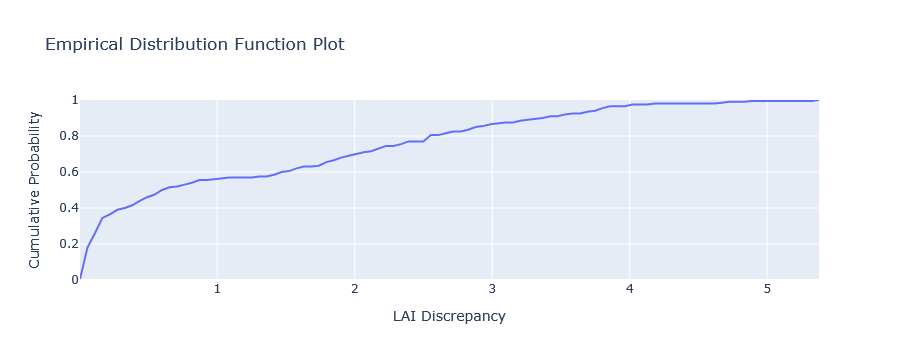

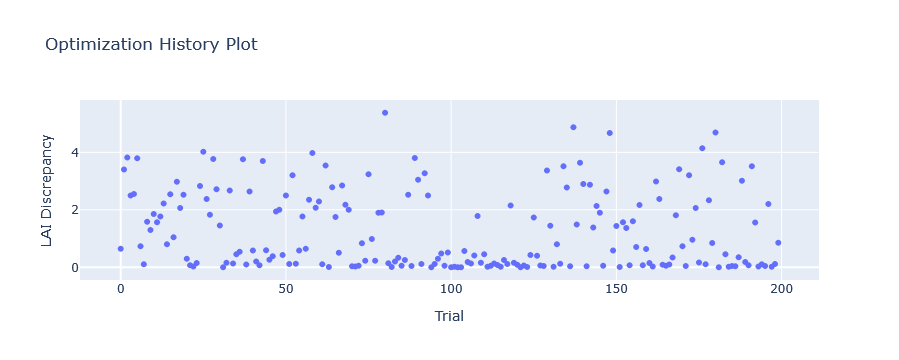

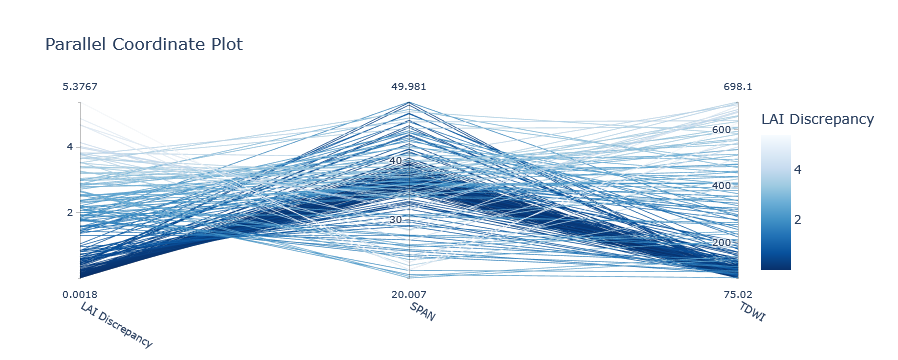

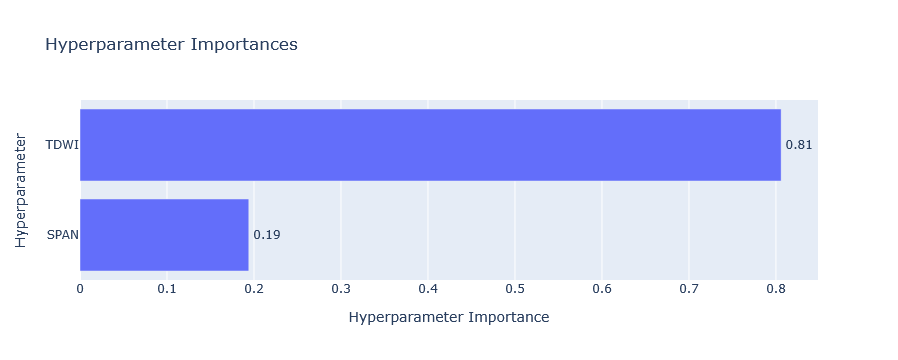

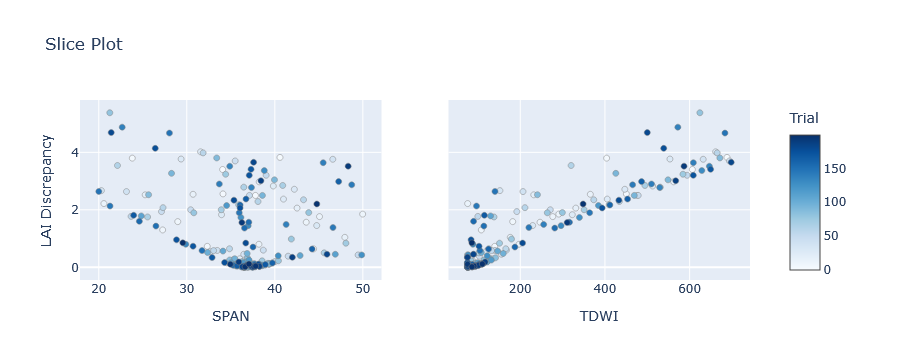

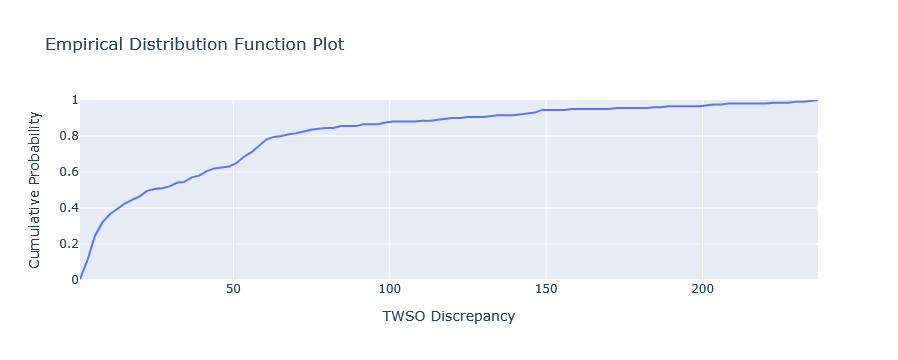

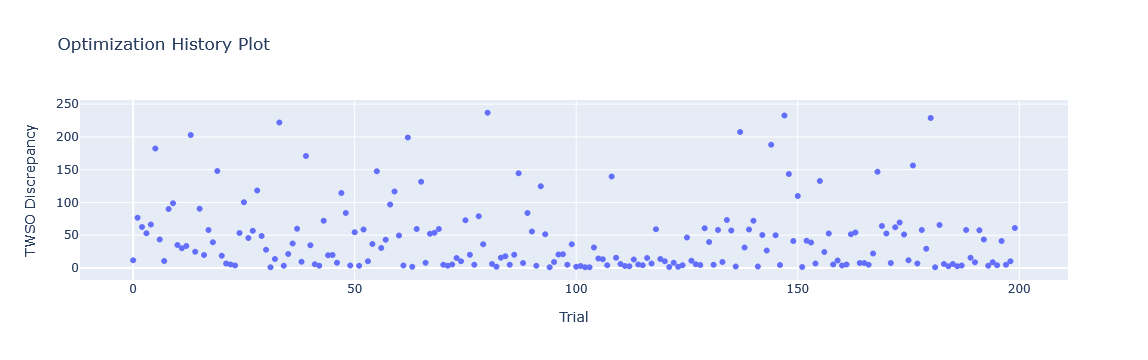

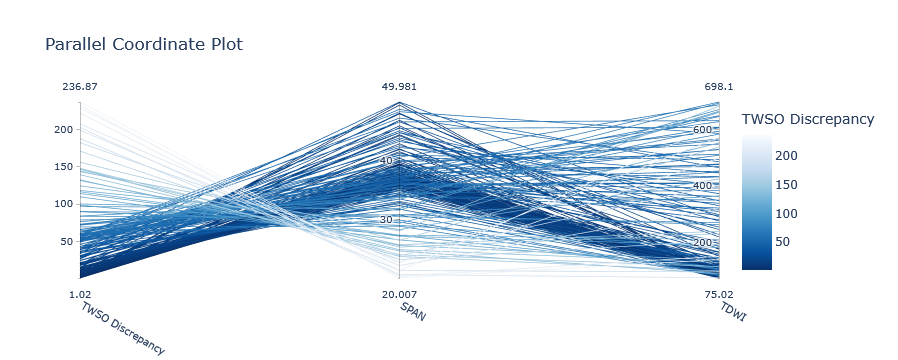

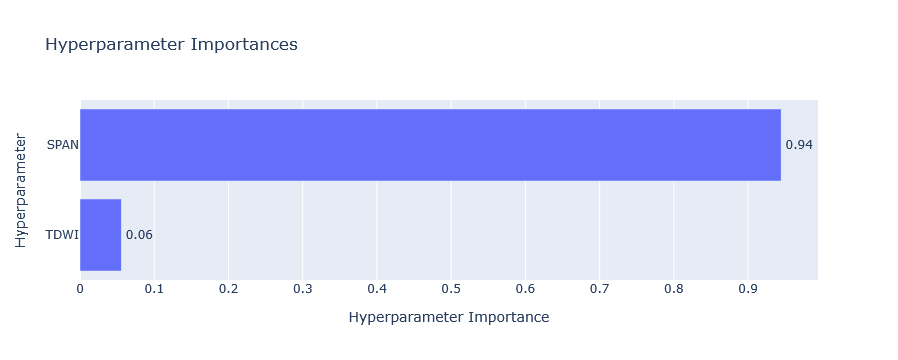

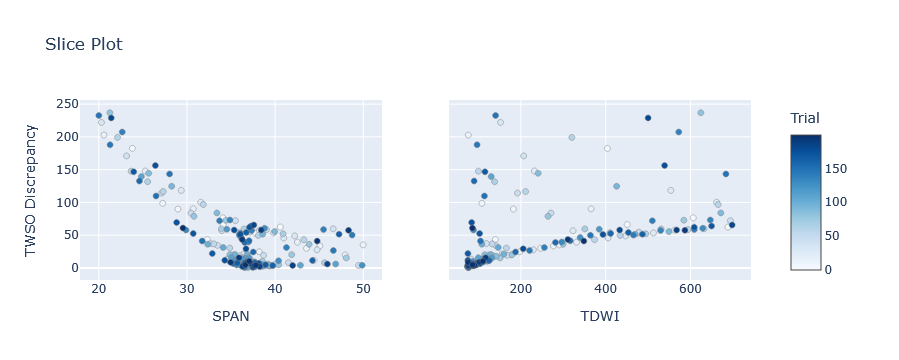

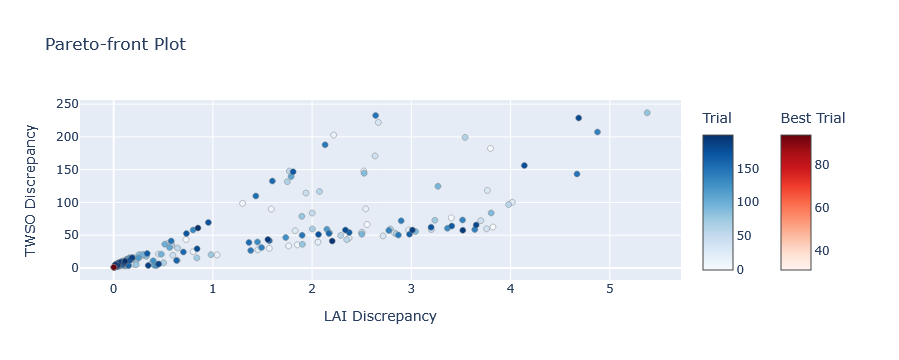

In [43]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

specification = OptimisationMethodModel(
    experiment_name="optuna_optimisation",
    parameter_spec=parameter_spec,
    observed_data=observed_data,
    method="tpes",
    output_labels=["LAI Discrepancy", "TWSO Discrepancy"],
    directions=[
        "minimize", "minimize"
    ],
    n_jobs=1,
    n_iterations=200,
    method_kwargs=dict(n_startup_trials=10),
)

calibrator = OptimisationMethod(
    calibration_func=objective, specification=specification, engine="optuna"
)

calibrator.specify().execute().analyze()

We can see some useful visualisations for both our objectives. But we'll focus on the Pareto-front plot.

For single-objective optimisation, you will end up with a single best solution with a single optimal parameter set. The aim of multi-objective optimisation is to identify the Pareto optimal set between your different objectives. Formally, a solution is Pareto optimal if no other solution can improve one objective without worsening at least one other objective. Informally, we want every objective to "win", and no objective to "lose".

In the Pareto-front plot, we see the trade-off between the LAI discrepancy and TWSO discrepancy objectives. We could then select one parameter set from our Pareto optimal set depending on whether we wish to favour LAI discrepancy or TWSO discrepancy. 